https://data-newbie.tistory.com/840#google_vignette     
데이터 셋 : https://archive.ics.uci.edu/dataset/502/online+retail+ii

In [13]:
# from ucimlrepo import fetch_ucirepo, list_available_datasets

# # check which datasets can be imported
# # list_available_datasets(search='Online Retail')
# list_available_datasets()
# # import dataset
# Bank_Marketing = fetch_ucirepo(id=352)
# df = Bank_Marketing.data.original
# # df = pd.DataFrame(data=Bank_Marketing.data.original)
# # df.to_csv('./bank_marketing.csv')
# display(df.head(3))

-------------------------------------
The following datasets are available:
-------------------------------------
Dataset Name                                                                            ID    
------------                                                                            --    
Abalone                                                                                 1     
Adult                                                                                   2     
Annealing                                                                               3     
Audiology (Standardized)                                                                8     
Auto MPG                                                                                9     
Automobile                                                                              10    
Balance Scale                                                                           12    
Balloons                       

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom


In [1]:
import datetime as dt

import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
from lifetimes import BetaGeoFitter
from lifetimes import GammaGammaFitter
from lifetimes.plotting import plot_period_transactions

def outlier_thresholds(dataframe, variable):
    quartile1 = dataframe[variable].quantile(0.01)
    quartile3 = dataframe[variable].quantile(0.99)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    
    return low_limit, up_limit

def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

# Additional info; 'outlier_thresholds' function, is so useful function you can use it in your data preparation process, it finds out outlier_thresholds and equals it either up_limit or low_limit. They are simultaneously used with replace_with_thresholds function. With the help of these two function, We will equalize our outlier thresholds to determined low_limit and up_limit values without taking a long time.
#Where you can find the dataset https://archive.ics.uci.edu/ml/datasets/Online+Retail+II

df_ = pd.read_excel("./예제 데이터셋/online_retail_II.xlsx", sheet_name="Year 2010-2011")
df = df_.copy()
df.describe().T

,count,mean,min,25%,50%,75%,max,std
Quantity,541910.0,9.552234,-80995.0,1.0,3.0,10.0,80995.0,218.080957
InvoiceDate,541910,2011-07-04 13:35:22.342307584,2010-12-01 08:26:00,2011-03-28 11:34:00,2011-07-19 17:17:00,2011-10-19 11:27:00,2011-12-09 12:50:00,NaN
Price,541910.0,4.611138,-11062.06,1.25,2.08,4.13,38970.0,96.759765
Customer ID,406830.0,15287.68416,12346.0,13953.0,15152.0,16791.0,18287.0,1713.603074


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541910 entries, 0 to 541909
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      541910 non-null  object        
 1   StockCode    541910 non-null  object        
 2   Description  540456 non-null  object        
 3   Quantity     541910 non-null  int64         
 4   InvoiceDate  541910 non-null  datetime64[ns]
 5   Price        541910 non-null  float64       
 6   Customer ID  406830 non-null  float64       
 7   Country      541910 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [3]:
df = df.dropna()
#For focusing on CLV prediction ,I fastly deleted all missing values.
df = df[~df["Invoice"].str.contains("C", na=False)]
# removing Cancellations from the data
replace_with_thresholds(df, "Quantity")
replace_with_thresholds(df, "Price")
#After our transactions, Let's check it out how describe looks like.
df.describe().T

,count,mean,min,25%,50%,75%,max,std
Quantity,397925.0,11.833709,1.0,2.0,6.0,12.0,298.5,25.534486
InvoiceDate,397925,2011-07-10 23:44:09.817126400,2010-12-01 08:26:00,2011-04-07 11:12:00,2011-07-31 14:39:00,2011-10-20 14:33:00,2011-12-09 12:50:00,NaN
Price,397925.0,2.893201,0.0,1.25,1.95,3.75,37.06,3.227143
Customer ID,397925.0,15294.308601,12346.0,13969.0,15159.0,16795.0,18287.0,1713.172738


In [4]:
df["TotalPrice"] = df["Quantity"] * df["Price"]

In [5]:
df.head(3)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6.0,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6.0,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8.0,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00


In [6]:
df['InvoiceDate'].max()

Timestamp('2011-12-09 12:50:00')

In [17]:
today_date = pd.to_datetime("2012-01-01")

In [27]:
cltv_df = df.groupby('Customer ID').agg(
    {
        'InvoiceDate': [lambda date: (date.max() - date.min()).days, 
                        lambda date: (today_date - date.min()).days],
        'Invoice': lambda num: num.nunique(),
        'TotalPrice': lambda TotalPrice: TotalPrice.sum()
    }
)
cltv_df.columns = cltv_df.columns.droplevel(0)
cltv_df.columns = ['recency', 'T', 'frequency', 'monetary']
cltv_df.head(5)

,recency,T,frequency,monetary
Customer ID,,,,
12346.0,0,347,1,310.44
12347.0,365,389,7,4310.00
12348.0,282,380,4,1770.78
12349.0,0,40,1,1491.72
12350.0,0,332,1,331.46


In [28]:
#Expressing "monetary value" as average earnings per purchase
cltv_df["monetary"] = cltv_df["monetary"] / cltv_df["frequency"]
# selection of monetary values greater than zero
cltv_df = cltv_df[cltv_df["monetary"] > 0]
# Expression of "recency "and "T" in weekly terms
cltv_df["recency"] = cltv_df["recency"] / 7
cltv_df["T"] = cltv_df["T"] / 7
# frequency must be greater than 1.
cltv_df = cltv_df[(cltv_df['frequency'] > 1)]
# After all trasformation ,lets check how our data looks like now.
cltv_df.head()

,recency,T,frequency,monetary
Customer ID,,,,
12347.0,52.142857,55.571429,7,615.714286
12348.0,40.285714,54.285714,4,442.695000
12352.0,37.142857,45.428571,8,219.542500
12356.0,43.142857,49.571429,3,937.143333
12358.0,21.285714,24.571429,2,575.210000


In [29]:
bgf = BetaGeoFitter(penalizer_coef=0.001)
#setting up the model
bgf.fit(cltv_df['frequency'],
        cltv_df['recency'],
        cltv_df['T'])
#fitting of all dataset

<lifetimes.BetaGeoFitter: fitted with 2845 subjects, a: 0.22, alpha: 12.19, b: 3.08, r: 2.23>

In [30]:
bgf.conditional_expected_number_of_purchases_up_to_time(1,
                                                        cltv_df['frequency'],
                                                        cltv_df['recency'],
                                                        cltv_df['T']).sort_values(ascending=False).head(10)
#1 = 1 week

Customer ID
15311.0    1.141849
14606.0    1.109516
14646.0    1.009916
13089.0    0.990528
12971.0    0.957095
17841.0    0.861459
13408.0    0.855110
18102.0    0.850075
13798.0    0.800731
14527.0    0.774029
dtype: float64

In [31]:
cltv_df["expected_purc_1_week"] = bgf.predict(1,
                                              cltv_df['frequency'],
                                              cltv_df['recency'],
                                              cltv_df['T'])
#conditional_expected_number_of_purchases_up_to_time and predict are basically same.
cltv_df.head(5)

,recency,T,frequency,monetary,expected_purc_1_week
Customer ID,,,,,
12347.0,52.142857,55.571429,7,615.714286,0.130792
12348.0,40.285714,54.285714,4,442.695000,0.080705
12352.0,37.142857,45.428571,8,219.542500,0.159970
12356.0,43.142857,49.571429,3,937.143333,0.078404
12358.0,21.285714,24.571429,2,575.210000,0.106077


In [32]:
bgf.predict(4,
            cltv_df['frequency'],
            cltv_df['recency'],
            cltv_df['T']).sort_values(ascending=False).head(10)

Customer ID
15311.0    4.545933
14606.0    4.417210
14646.0    4.019927
13089.0    3.943343
12971.0    3.810355
17841.0    3.429640
13408.0    3.404375
18102.0    3.384130
13798.0    3.187849
14527.0    3.081456
dtype: float64

In [34]:
cltv_df["expected_purc_1_month"] = bgf.predict(4,
 cltv_df['frequency'],
 cltv_df['recency'],
 cltv_df['T'])
cltv_df.sort_values("expected_purc_1_month", ascending=False).head(10)
#Sorted the variables accourding to 1month expected purchase prediction.

,recency,T,frequency,monetary,expected_purc_1_week,expected_purc_1_month
Customer ID,,,,,,
15311.0,53.285714,56.428571,91,667.779121,1.141849,4.545933
14606.0,53.142857,56.428571,93,130.139032,1.109516,4.417210
14646.0,50.428571,53.714286,74,3596.804392,1.009916,4.019927
13089.0,52.285714,55.857143,97,606.362474,0.990528,3.943343
12971.0,52.571429,56.285714,86,127.485872,0.957095,3.810355
17841.0,53.000000,56.428571,124,330.134355,0.861459,3.429640
13408.0,53.000000,56.428571,62,453.500645,0.855110,3.404375
18102.0,52.285714,55.571429,60,3859.739083,0.850075,3.384130
13798.0,52.857143,56.285714,57,650.908509,0.800731,3.187849


In [36]:
bgf.predict(4,cltv_df['frequency'],cltv_df['recency'],cltv_df['T']).sum()
# OUTPUT = 1777.1450731636987
#It is a transaction amount that is expected in the next month.

1458.2961039353581

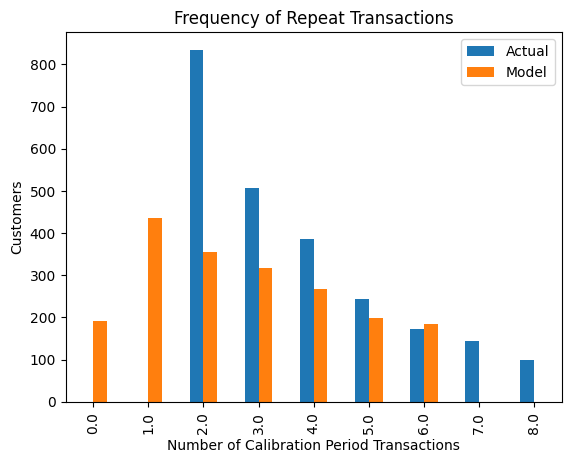

In [37]:
plot_period_transactions(bgf)
plt.show()